# Man-in-the-Middle Attacks on MQTT-based IoT Using BERT Based Adversarial Message Generation

Welcome to my Google Colab for my paper on attacking MQTT-based IoT devices using a GAN inspired message generation using BERT. The purpose of this code is to generate malicious messages based on what is passed in.

**Warning**: This entire program may take some time to process.

## Dependencies

In [1]:
!pip install transformers

In [2]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
from nltk.corpus import wordnet
import random
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

## Function Definitions

In [5]:
#Generator Function for Non-Numeric Words
#X is a pandas Series of a sentence
#gamma is the number of iterations
#returns a series of modified messages (might be modified)
def generatorWords(X,gamma):

  fakeX = []

  if len(X.unique()) < len(X)/2: #if the number of unique values is less than half of the set
    uniqueVals = X.unique()
    fakeX = []
    for i in range(len(X)):
      fakeX.append(random.choice(uniqueVals))
  else:
    for index, value in X.items():
      words = value.split(" ")
      adjs = []
      choosenWord = ""
      pos_all = dict()
      antonyms = []

      #priortize adjectives
      for w in words:
        #print(w)
        pos_l = set()
        for tmp in w.synsets(w):
            if tmp.name().split('.')[0] == w:
                pos_l.add(tmp.pos())
        pos_all[w] = pos_l

      #in the list of word classes we single out the adjectives
      for a in pos_all:
        if "a" in pos_all[a]:
          adjs.append(a)

      #here we choose which word to flip
      if adjs:
        choosenWord = adjs[0] if len(adjs) > 1 else adjs[0]
      else:
        choosenWord = words[0] if len(words) > 1 else words[0]

      #find antonyms of the choosen word
      for syn in wordnet.synsets(choosenWord):
        for lm in syn.lemmas():
            if lm.antonyms():
                antonyms.append(lm.antonyms()[0].name())
      if antonyms:
        new = [antonyms[gamma] if x==choosenWord else x for x in words]
      else:
        new = [x if x==choosenWord else x for x in words]
      fakeX.append(" ".join(new))
  return pd.Series(fakeX)


In [6]:
#Generator Function For Numeric Data Points
#X is a series of numbers
def generatorNum(X,gamma):
  xHat = np.mean(X)
  sx = np.std(X)
  randomUpper = (xHat) + (sx * gamma)
  randomLower = (xHat) - (sx * gamma)
  beta = []
  for i in range(int(len(X))):
      beta.append(random.randrange(int(randomLower),int(randomUpper)))
  beta = list(map(str, beta))
  #print(beta)
  return pd.Series(beta)

In [7]:
#Generator That Points Data Into The Right Generator
#Returns an dataframe that contains fake data and real data, each with labels 0
#  being real and 1 being false
def generator(df,gamma):
  mDF = df.copy()
  mDF["temperature"] = generatorNum(df["temperature"],gamma)
  mDF["outlook"] = generatorWords(df["outlook"],0)
  mDF["wind"] = generatorWords(df["wind"],0)
  mDF["humidity"] = generatorNum(df["humidity"],gamma)
  fakeData = addLabel(makeSentence(mDF),1) #column 0 is sentences, column 1 is label
  realData = addLabel(makeSentence(df),0)  #Label 0 means data, label 1 means fake data
  return(pd.concat([fakeData,realData],axis=0),fakeData)

In [8]:
#Merges All DataFrame Columns Into A Single Sentence
#Returns a series of the merged DataFrame columns
def makeSentence(df):
  #df is a data frame
  df = df.copy().applymap(str)
  seriesA = df[df.columns[0:]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
  return seriesA

In [9]:
#Adds a label columns to series for classification
#Returns dataframe of two columns, the series and the labels
def addLabel(series,label):
  #takes in a pandas series and a label
  #returns a dataframe
  labels = []
  [labels.append(label) for i in range(len(series))]
  labels = pd.Series(labels)
  return pd.concat([series,labels],axis=1)

In [10]:
#Discriminiator for deteremining whether data is malicious or not
#Returns new gamma, other parameters are for testing and graphing purposes
def discriminator(X, gamma, rho):
  #takes in dataframe in BERT format of sentence and label
  #returns a new gamme to generate data with
  score,indexes,fn,total = BERT(X)
  print("score: " + str(score))
  #if 0.35 < score < 0.55:
  ##  return None
  #else:
  return (score,gamma + rho,indexes,fn,total)

In [11]:
def BERT(df):
  #df is a dataframe containing sentences and labels
  #BERT returns a accruacy and indexes of false negatives

  #tokenize
  tokenized = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) #pad
  attention_mask = np.where(padded != 0, 1, 0)                            #apply masks
  input_ids = torch.tensor(padded)
  attention_mask = torch.tensor(attention_mask)                           #put masks through torch tensor

  #run through bert
  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask)
  features = last_hidden_states[0][:,0,:].numpy()
  labels = df[1]
  return(regression(features,labels))

In [12]:
#Takes BERT pretrained output and put's it through a multi-  layer perceptron
#Returns accuracy and indexes of false negatives
def regression(features,labels):
  train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)
  #lr_clf = LogisticRegression(max_iter=500)
  #lr_clf.fit(train_features, train_labels)
  #return(lr_clf.score(test_features, test_labels))
  NeuralNetwork = MLPClassifier(solver='adam', activation="logistic", random_state=1,max_iter=5000)
  NeuralNetwork.fit(train_features, train_labels)
  y2 = NeuralNetwork.predict(test_features)
  y2 = pd.Series(NeuralNetwork.predict(test_features))
  #print(test_labels)
  i=0
  indexes = []
  for index, value in test_labels.items():
    if value == 1:
      if y2[i] == 0:
        indexes.append(index)
    i+=1
  #print(indexes)
  tn, fp, fn, tp = confusion_matrix(test_labels, y2).ravel()
  #fp = confusion_matrix(test_labels, y2)[0][1]
  total = len(test_labels)
  return (NeuralNetwork.score(test_features,test_labels),indexes,fn,total)

In [13]:
def indexToEntry(X,indexes):
  #finds list of indexes in X and returns a dataframe with the entries
  entries = []
  for i in indexes:
    entries.append(X.iloc[i])
  return(pd.DataFrame(entries))

In [14]:
def logisticRegression(train_features, test_features, train_labels, test_labels):
  lr_clf = LogisticRegression(max_iter=500)
  lr_clf.fit(train_features, train_labels)
  #print(lr_clf.score(test_features, test_labels))
  y_pred = lr_clf.predict(test_features)
  score = lr_clf.score(test_features, test_labels)
  tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
  return(fn,score)

In [15]:
def RandomForest(train_features, test_features, train_labels, test_labels):
  RandForest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
  RandForest.fit(train_features, train_labels)
  forest_pred = RandForest.predict(test_features)
  score = RandForest.score(test_features,test_labels)
  tn, fp, fn, tp = confusion_matrix(test_labels, forest_pred).ravel()
  return(fn,score)


In [16]:
def KNN(train_features, test_features, train_labels, test_labels):
  #K Nearest Neighbor With Optimal Neighbor (1)
  knn = KNeighborsClassifier(n_neighbors = 1)
  knn.fit(train_features,train_labels)
  score = knn.score(test_features, test_labels)
  y_pred = knn.predict(test_features)
  tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
  #print(confusion_matrix(test_labels, y_pred))
  #print(classification_report(y_test, y_pred))
  return(fn,score)

In [17]:
def MLP(train_features, test_features, train_labels, test_labels):
  NeuralNetwork = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
  NeuralNetwork.fit(train_features, train_labels)
  nn_pred = NeuralNetwork.predict(test_features)
  score = NeuralNetwork.score(test_features,test_labels)
  #print(confusion_matrix(test_labels, nn_pred))
  tn, fp, fn, tp = confusion_matrix(test_labels, nn_pred).ravel()
  return(fn,score)

In [18]:
def SVM(train_features, test_features, train_labels, test_labels):
  clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  clf.fit(train_features,train_labels)
  svmPred = clf.predict(test_features)
  score = clf.score(test_features,test_labels)
  #print(confusion_matrix(test_labels, pred))
  tn, fp, fn, tp = confusion_matrix(test_labels, svmPred).ravel()
  return(fn,score)

In [19]:
def tests(df,mDF):
  ogData = addLabel(makeSentence(df),0)
  testData = pd.concat([ogData,mDF])
  tokenized = testData[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  train_features, test_features, train_labels, test_labels = train_test_split(padded, testData[1], random_state=42)
  lrFN,lrScore = logisticRegression(train_features, test_features, train_labels, test_labels)
  rfFN,rfScore = RandomForest(train_features, test_features, train_labels, test_labels)
  knnFN,knnScore = KNN(train_features, test_features, train_labels, test_labels)
  mlpFN,mlpScore = MLP(train_features, test_features, train_labels, test_labels)
  svmFN,svmScore = SVM(train_features, test_features, train_labels, test_labels)
  #print("test_labels: " + str(len(test_labels)))
  return(lrFN,lrScore,rfFN,rfScore,knnFN,knnScore,mlpFN,mlpScore,svmFN,svmScore)

## Data Processing

In [20]:
df = pd.read_csv('https://raw.githubusercontent.com/HenryCWong/adversarialBERTMessages/master/weather_sample_data.csv', delimiter=',')

In [21]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [22]:
df.head()

,temperature,outlook,wind,humidity
0,40,cloudy,E,14
1,51,partly cloudy,SE,95
2,47,severe_thunderstorm,SE,88
3,45,thunderstorm,W,35
4,43,sunny,SE,33


## Algorithm

In [23]:
X,mDF = generator(df,1)

In [24]:
mDF

,0,1
0,"47,rain,None,51",1
1,"54,cloudy,N,52",1
2,"51,rain,E,26",1
3,"44,sunny,NE,63",1
4,"51,cloudy,None,33",1
...,...,...
495,"47,partly cloudy,S,61",1
496,"48,partly cloudy,N,31",1
497,"49,partly cloudy,E,41",1
498,"44,cloudy,W,38",1


In [25]:
tests(df,mDF) #logistic regression, random forest, knn, mlp, svm

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


(70, 0.46, 59, 0.548, 52, 0.512, 94, 0.492, 52, 0.54)

In [26]:
score,gamma,indexes,jp,total = discriminator(X,1,1)

score: 0.716


In [27]:
print(jp)
print(total)

16
250


In [28]:
malDF = indexToEntry(X,indexes)

In [29]:
malDF.head()

,0,1
210,"45,thunderstorm,NE,59",1
59,"43,thunderstorm,NE,41",1
96,"50,sunny,NE,40",1
439,"54,thunderstorm,SW,22",1
221,"47,rain,NE,20",1


### Bulk of the Algorithm

In [30]:

gamma = 1
rho = .1
#All these lists are set up for creating insights
sets = []
scores = []
fns = []
totals = []
gammas = []
lrFNs = []
rfFNs = []
knnFNs = []
mlpFNs = []
svmFNs = []
lrScores = []
rfScores = []
knnScores = []
mlpScores = []
svmScores = []
j = 0
while j < 30:
  X,mDF = generator(df,gamma)
  #print(gamma)
  score,gamma, indexes,fn,total = discriminator(X,gamma,rho)
  scores.append((j,score))
  #malDF = pd.concat([malDF,indexToEntry(X,indexes)])
  lrFN,lrScore,rfFN,rfScore,knnFN,knnScore,mlpFN,mlpScore,svmFN,svmScore = tests(df,mDF)
  #lists for stats
  lrFNs.append(lrFN)
  rfFNs.append(rfFN)
  knnFNs.append(knnFN)
  mlpFNs.append(mlpFN)
  svmFNs.append(svmFN)
  lrScores.append(lrScore)
  rfScores.append(rfScore)
  knnScores.append(knnScore)
  mlpScores.append(mlpScore)
  svmScores.append(svmScore)
  sets.append(indexToEntry(X,indexes))
  fns.append(fn)
  totals.append(total)
  gammas.append(gamma)
  j+=1


score: 0.764


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


score: 0.716
score: 0.672
score: 0.616


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


score: 0.588
score: 0.544
score: 0.536
score: 0.528


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


score: 0.504
score: 0.544
score: 0.604


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score: 0.64
score: 0.596
score: 0.676


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


score: 0.636


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


score: 0.616
score: 0.664


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score: 0.712
score: 0.708


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score: 0.704


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score: 0.792
score: 0.744
score: 0.792


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score: 0.764


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score: 0.832


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score: 0.78


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score: 0.78


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


score: 0.816


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score: 0.888


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score: 0.776


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [31]:
sortedScores = sorted(scores, key=lambda tup: tup[1])

In [32]:
index,score = sortedScores[0]
malDF = sets[index]
for i in range(1,7):
  index, score = sortedScores[i]
  malDF = pd.concat([malDF,sets[index]])

In [33]:
malDF

,0,1
136,"50,severe_thunderstorm,SE,7",1
280,"57,sunny,SW,40",1
319,"53,sunny,SW,30",1
174,"52,rain,N,64",1
371,"38,rain,SE,59",1
...,...,...
204,"51,cloudy,SW,13",1
306,"58,thunderstorm,E,85",1
109,"43,thunderstorm,NW,16",1
77,"52,severe_thunderstorm,None,23",1


In [34]:
df["temperature"].std()

6.261462434898679

In [35]:
#malDF = pd.concat([malData,addLabel(makeSentence(df),0)])

## Graphing

In [36]:
print(gammas)
print(fns)
print(totals)
print(scores)

[1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000004, 1.5000000000000004, 1.6000000000000005, 1.7000000000000006, 1.8000000000000007, 1.9000000000000008, 2.000000000000001, 2.100000000000001, 2.200000000000001, 2.300000000000001, 2.4000000000000012, 2.5000000000000013, 2.6000000000000014, 2.7000000000000015, 2.8000000000000016, 2.9000000000000017, 3.0000000000000018, 3.100000000000002, 3.200000000000002, 3.300000000000002, 3.400000000000002, 3.500000000000002, 3.6000000000000023, 3.7000000000000024, 3.8000000000000025, 3.9000000000000026, 4.000000000000003]
[15, 16, 15, 46, 31, 59, 61, 65, 71, 63, 46, 50, 54, 41, 43, 53, 51, 49, 38, 29, 36, 51, 46, 51, 27, 43, 38, 28, 21, 44]
[250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250]
[(0, 0.764), (1, 0.716), (2, 0.672), (3, 0.616), (4, 0.588), (5, 0.544), (6, 0.536), (7, 0.528), (8, 0.504), (9, 0.544), (10, 0.604), (11, 0.64), (12, 0

In [37]:
for a in scores:
  print(a[1])

0.764
0.716
0.672
0.616
0.588
0.544
0.536
0.528
0.504
0.544
0.604
0.64
0.596
0.676
0.636
0.616
0.664
0.712
0.708
0.704
0.792
0.744
0.792
0.764
0.832
0.78
0.78
0.816
0.888
0.776


In [38]:
numScores = []
[numScores.append(a[1]) for a in scores]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

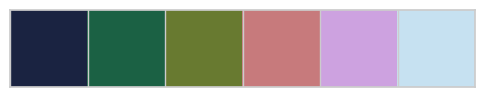

In [39]:
sns.set_style("whitegrid")
sns.palplot(sns.color_palette("cubehelix", 6))
sns.set_palette("cubehelix",6)

<Axes: xlabel='Gamma', ylabel='Accuracy'>

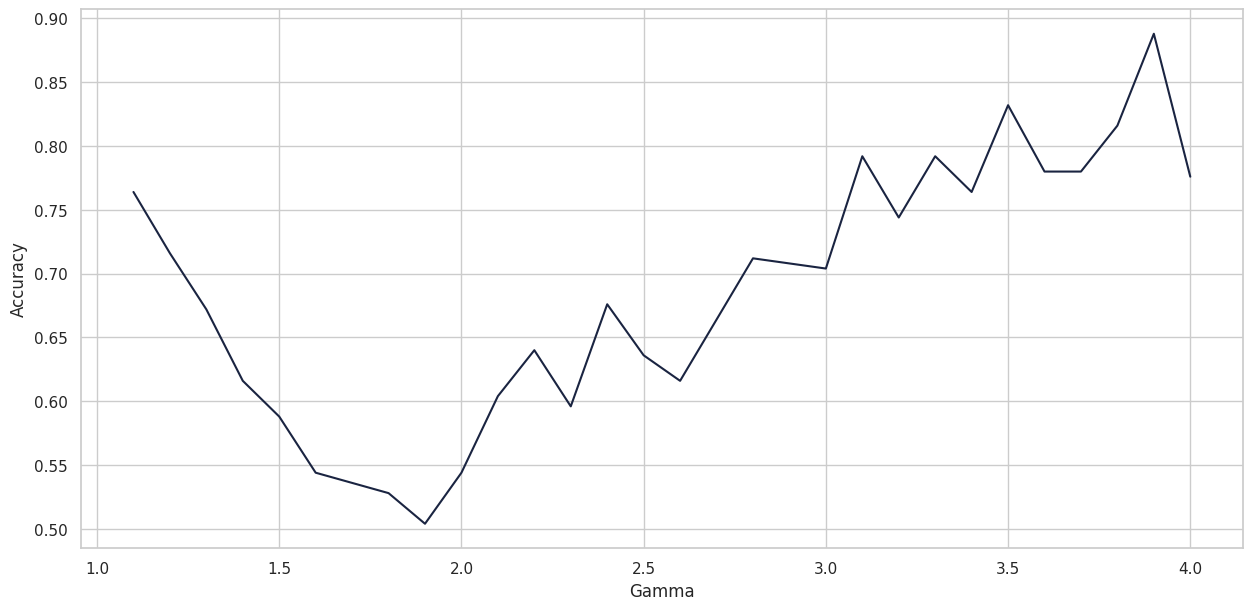

In [40]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set(xlabel='Gamma', ylabel='Accuracy')
sns.lineplot(ax=ax,x=gammas,y=numScores)
#ax = sns.lineplot(x=gammas, y=numScores)


<Axes: xlabel='Gamma', ylabel='Number of False Negatives'>

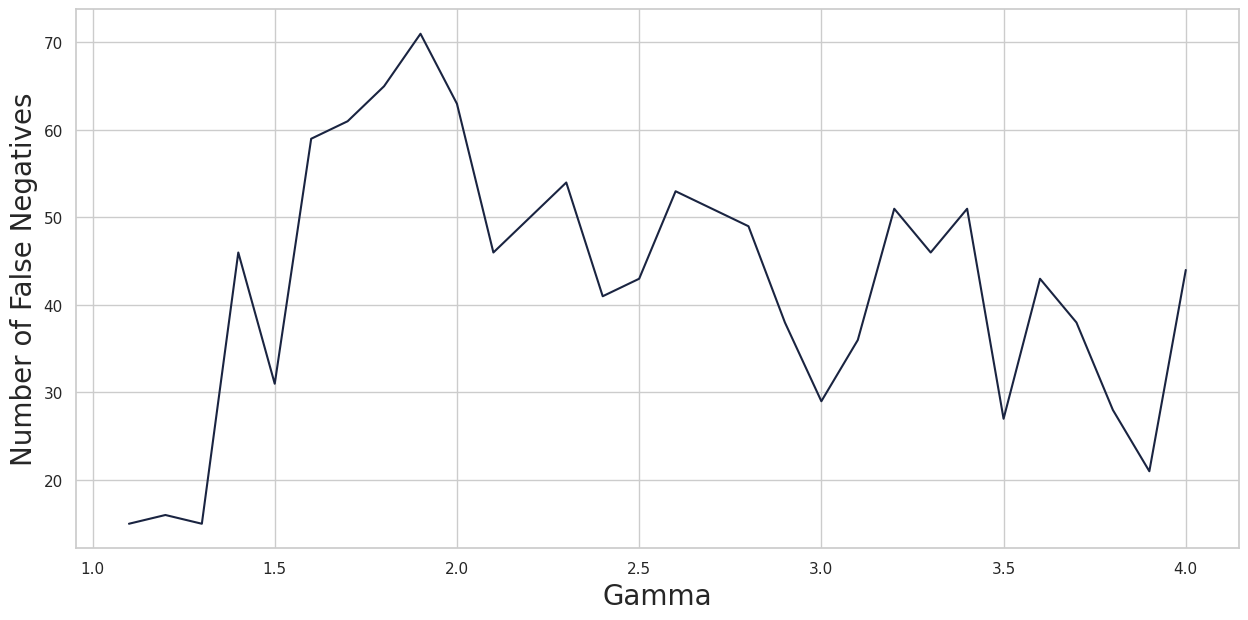

In [41]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_xlabel('Gamma',fontsize=20);
ax.set_ylabel('Number of False Negatives',fontsize=20);
#ax.set(xlabel='Gamma', ylabel='False Positives')
sns.lineplot(ax=ax,x=gammas,y=fns,markers=True)
#ax = sns.lineplot(x=gammas, y=numScores)


In [42]:
fpRatio = []
for i in range(len(fns)):
  fpRatio.append(fns[i]/totals[i])

<Axes: xlabel='Gamma', ylabel='False Negatives / Total Data Points'>

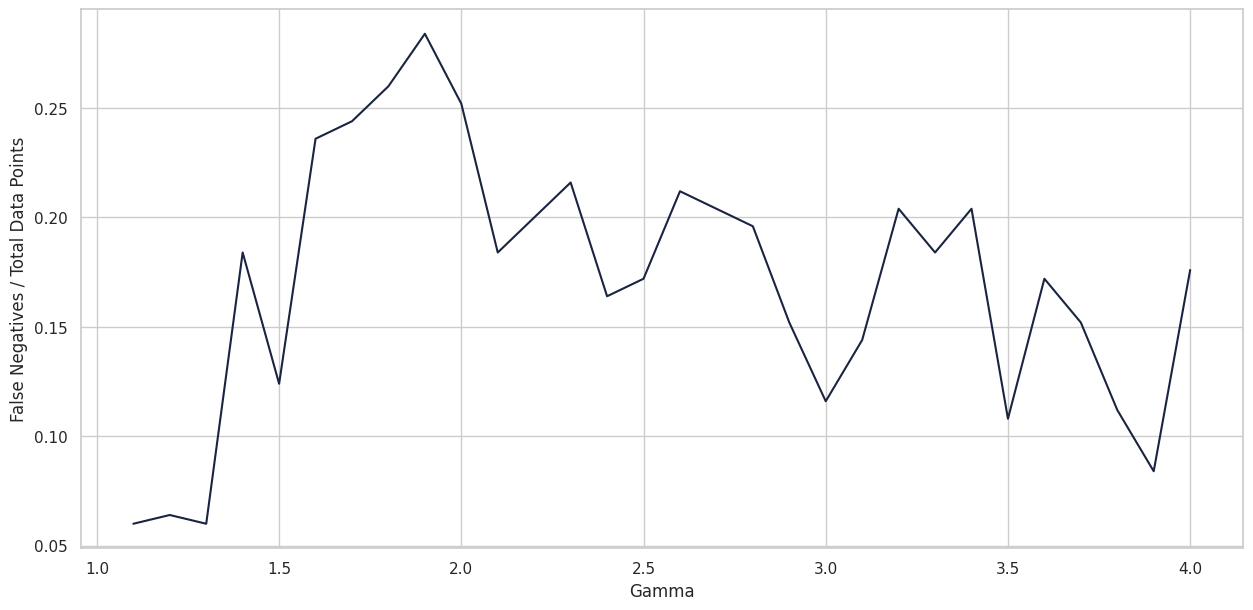

In [43]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set(xlabel='Gamma', ylabel='False Negatives / Total Data Points')
sns.lineplot(ax=ax,x=gammas,y=fpRatio)


In [44]:
d = {"gamma":gammas,"score":numScores,"fn":fns}
nDF = pd.DataFrame(data=d)

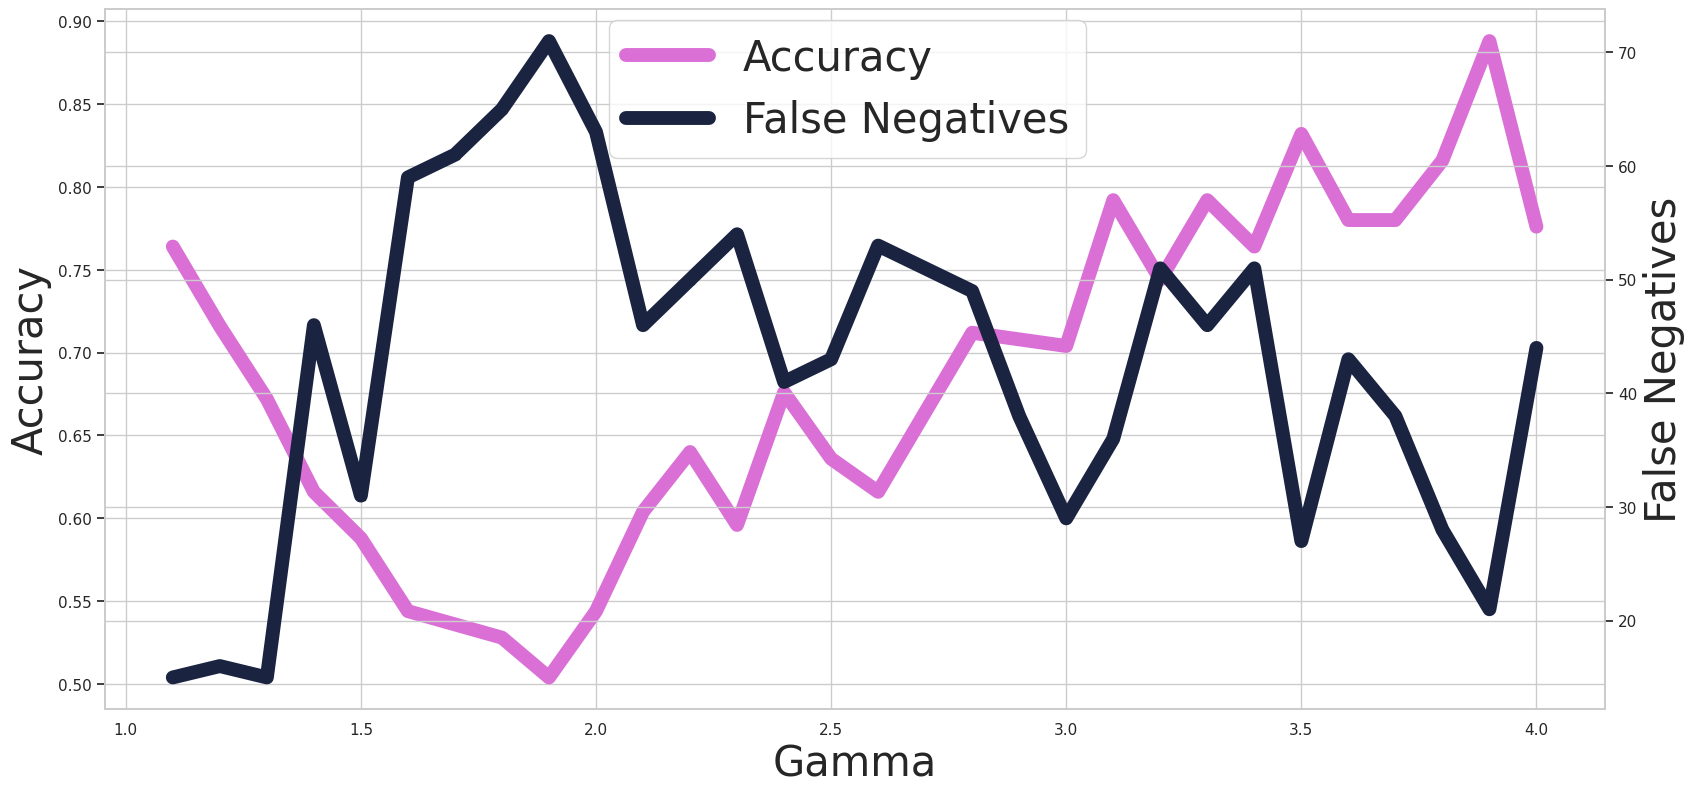

In [45]:
a4_dims = (15, 7)

fig = plt.figure(figsize=a4_dims)
a1 = fig.add_axes([0,0,1,1])
a1.plot(nDF["gamma"],nDF["score"],color="orchid",marker="x",linewidth=10.0)
a1.set_ylabel('Accuracy',fontsize = 30)
a1.set_xlabel("Gamma",fontsize = 30)
a2 = a1.twinx()
a2.plot(nDF["gamma"],nDF["fn"],marker="s",linewidth=10.0)
a2.set_ylabel('False Negatives',fontsize = 30)
a2.set_xlabel("Gamma",fontsize = 30)
fig.legend(labels = ('Accuracy','False Negatives'),loc='upper center',prop={'size': 30})
plt.show()

In [46]:
#Iterpolation attempt
from scipy.interpolate import interp1d


   Weight_A
0     0.764
1     0.616
2     0.536
3     0.544
4     0.596
5     0.616
6     0.708
7     0.744
8     0.832
9     0.816


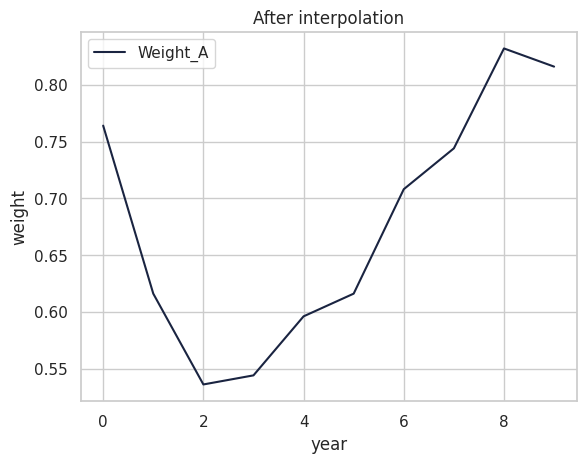

In [47]:
f1 = interp1d(nDF["gamma"], nDF['score'],kind='cubic')
f2 = interp1d(nDF["gamma"], nDF['fn'],kind='cubic')

xnew = np.arange(1.1,4,.3)
df2 = pd.DataFrame()
df2['Weight_A'] = f1(xnew)
#df2['Weight_B'] = f2(xnew)
print(df2)
ax2 = df2.plot.line()
ax2.set_title('After interpolation')
ax2.set_xlabel("year")
ax2.set_ylabel("weight")


plt.show()

In [48]:
d = {"Logistic Regression":lrFNs,"Random Forest":rfFNs,"K Nearest Neighbor":knnFNs,"Multi-Layer Perceptron":mlpFNs,"Support Vector Classification":svmFNs,"gamma":gammas}
#n = np.array([lrFNs,rfFNs,knnFNs,mlpFNs,svmFNs])
mlstuffs = pd.DataFrame(d)

In [49]:
print(svmScores)

[0.54, 0.488, 0.528, 0.492, 0.452, 0.504, 0.524, 0.476, 0.492, 0.528, 0.536, 0.536, 0.496, 0.608, 0.62, 0.58, 0.632, 0.648, 0.612, 0.648, 0.728, 0.716, 0.716, 0.724, 0.72, 0.756, 0.732, 0.704, 0.756, 0.728]


In [50]:
s = {"Logistic Regression":lrScores,"Random Forest":rfScores,"K Nearest Neighbor":knnScores,"Multi-Layer Perceptron":mlpScores,"Support Vector Classification":svmScores,"gamma":gammas}
scoreStuffs = pd.DataFrame(s)

In [51]:
meltedScores = scoreStuffs.melt(id_vars=['gamma'])
meltedScores = scoreStuffs.melt(id_vars=['gamma'])
meltedScores.columns = ["gamma","Classification Model","Accuracy"]

In [52]:
meltedML = mlstuffs.melt(id_vars=['gamma'])
meltedML.columns = ["gamma","Classification Model","Number of False Negatives"]

In [53]:
meltedML.head()

,gamma,Classification Model,Number of False Negatives
0,1.1,Logistic Regression,62
1,1.2,Logistic Regression,75
2,1.3,Logistic Regression,69
3,1.4,Logistic Regression,71
4,1.5,Logistic Regression,64


<Axes: xlabel='Gamma', ylabel='Number of False Negatives'>

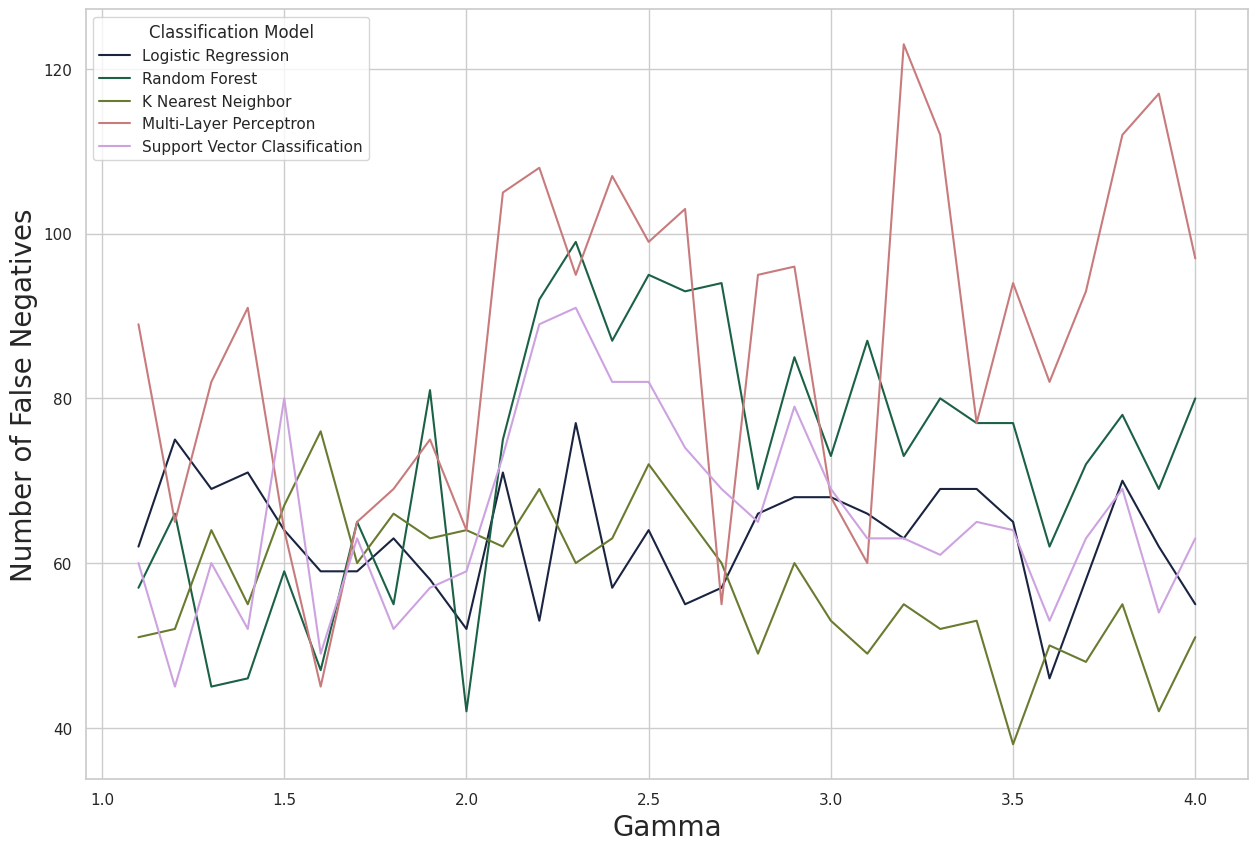

In [54]:
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
#ax.set(xlabel='Gamma', ylabel='False Negatives')
ax.set_xlabel('Gamma',fontsize=20);
ax.set_ylabel('Number of False Negatives',fontsize=20);
sns.lineplot(ax=ax,x="gamma",y="Number of False Negatives",hue="Classification Model",data=meltedML)
#this displays during trainig and testing "how many malicious messages made it through" at different gammas

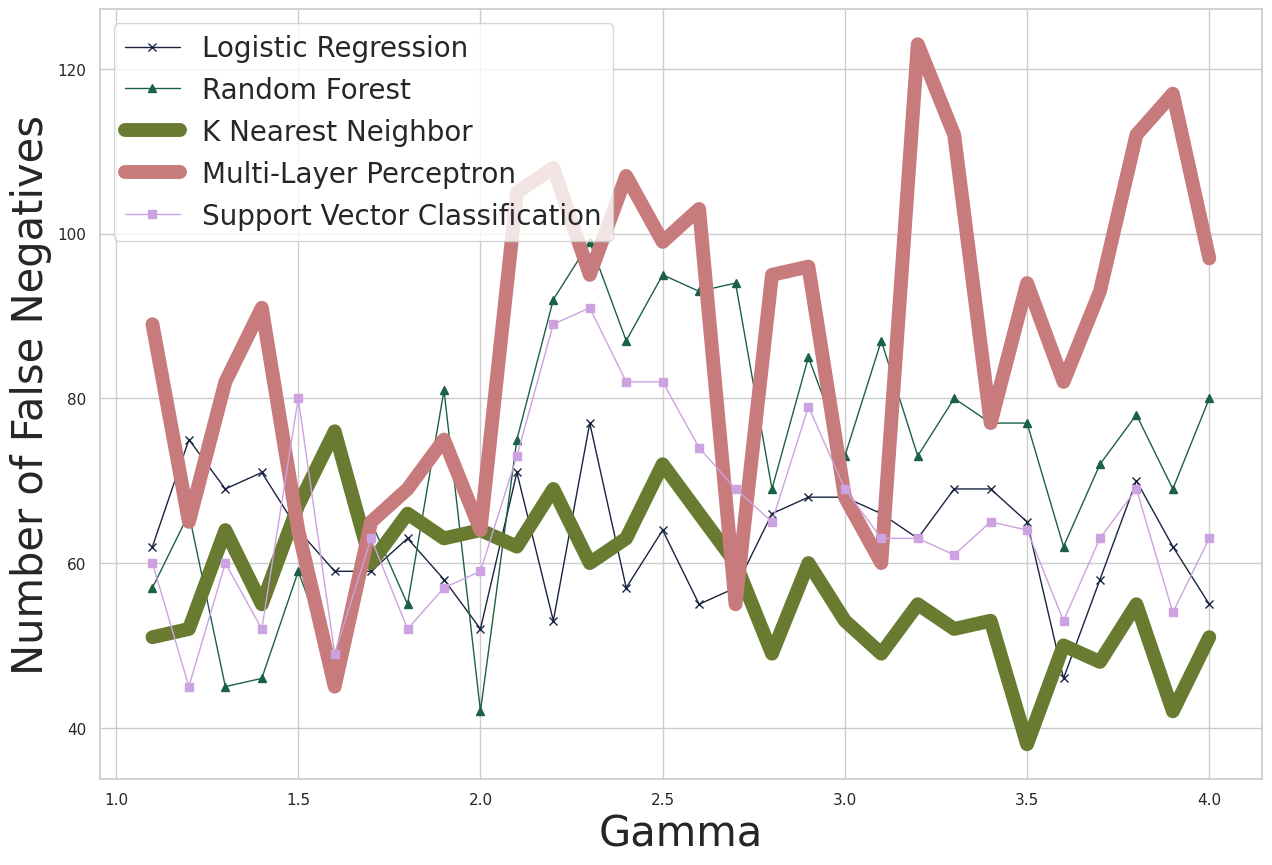

In [55]:
#plt.plot(meltedML[meltedML["Classification Model"] == "Logistic Regression"])
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
#ax.set(xlabel='Gamma', ylabel='False Negatives')
ax.set_xlabel('Gamma',fontsize=30);
ax.set_ylabel('Number of False Negatives',fontsize=30);
models = ["Logistic Regression","Random Forest","K Nearest Neighbor","Multi-Layer Perceptron","Support Vector Classification"]
markers = ["x","^","*","x","s"]
for i in range(len(models)):
  a = meltedML[meltedML["Classification Model"] == models[i]]
  if models[i] == "Multi-Layer Perceptron" or models[i] == "K Nearest Neighbor":
    plt.plot(a["gamma"],a["Number of False Negatives"],linewidth=10.0,marker=markers[i])
  else:
    plt.plot(a["gamma"],a["Number of False Negatives"],linewidth=1.0,marker=markers[i])
plt.legend(models,prop={'size': 20})

#lr = meltedML[meltedML["Classification Model"] == "Logistic Regression"]
#rf = meltedML[meltedML["Classification Model"] == "Random Forest"]

#plt.plot(lr["gamma"],lr["Number of False Negatives"])
#plt.plot(rf["gamma"],rf["Number of False Negatives"])


In [56]:
meltedScores.head()

,gamma,Classification Model,Accuracy
0,1.1,Logistic Regression,0.500
1,1.2,Logistic Regression,0.444
2,1.3,Logistic Regression,0.480
3,1.4,Logistic Regression,0.460
4,1.5,Logistic Regression,0.496


<Axes: xlabel='Gamma', ylabel='Accuracy'>

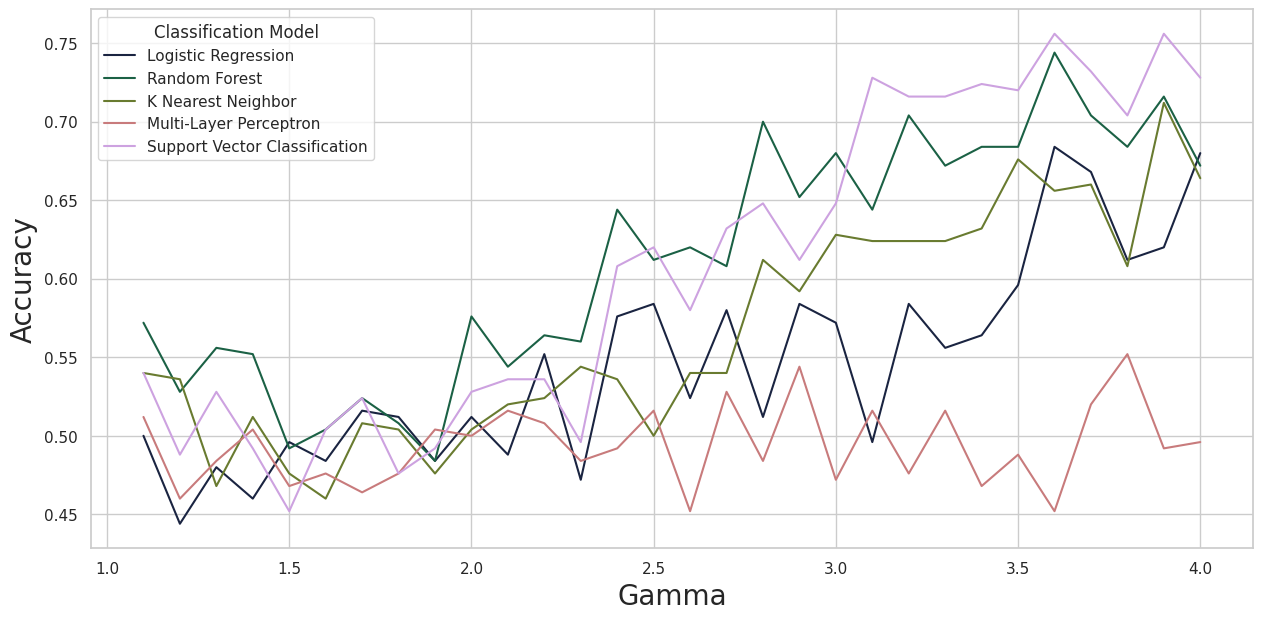

In [57]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
#ax.set(xlabel='Gamma', ylabel='False Negatives')
ax.set_xlabel('Gamma',fontsize=20);
ax.set_ylabel('Accuracy',fontsize=20);
sns.lineplot(ax=ax,x="gamma",y="Accuracy",hue="Classification Model",data=meltedScores)
#this displays during trainig and testing "how many malicious messages made it through" at different gammas

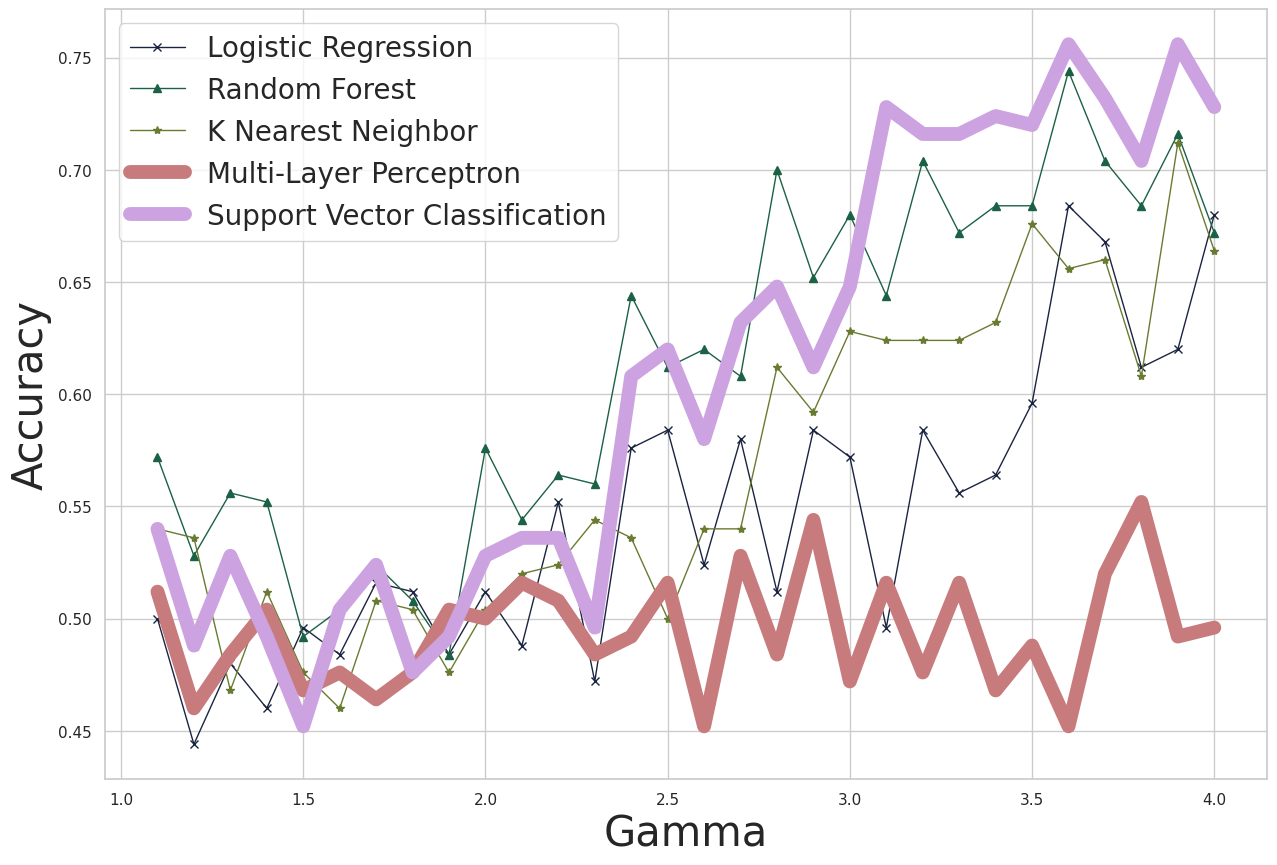

In [58]:
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_xlabel('Gamma',fontsize=30);
ax.set_ylabel('Accuracy',fontsize=30);
models = ["Logistic Regression","Random Forest","K Nearest Neighbor","Multi-Layer Perceptron","Support Vector Classification"]
markers = ["x","^","*","x","s"]
for i in range(len(models)):
  a = meltedScores[meltedScores["Classification Model"] == models[i]]
  if models[i] == "Multi-Layer Perceptron" or models[i] == "Support Vector Classification":
    plt.plot(a["gamma"],a["Accuracy"],linewidth=10.0,marker=markers[i])
  else:
    plt.plot(a["gamma"],a["Accuracy"],linewidth=1.0,marker=markers[i])
plt.legend(models,prop={'size': 20})

#lr = meltedML[meltedML["Classification Model"] == "Logistic Regression"]
#rf = meltedML[meltedML["Classification Model"] == "Random Forest"]

#plt.plot(lr["gamma"],lr["Number of False Negatives"])
#plt.plot(rf["gamma"],rf["Number of False Negatives"])


# Testing

In [59]:
ogData = addLabel(makeSentence(df),0)

In [60]:
testData = pd.concat([ogData,malDF])

In [61]:
testData

,0,1
0,"40,cloudy,E,14",0
1,"51,partly cloudy,SE,95",0
2,"47,severe_thunderstorm,SE,88",0
3,"45,thunderstorm,W,35",0
4,"43,sunny,SE,33",0
...,...,...
204,"51,cloudy,SW,13",1
306,"58,thunderstorm,E,85",1
109,"43,thunderstorm,NW,16",1
77,"52,severe_thunderstorm,None,23",1


In [62]:
testData[testData[1] == 1]

,0,1
136,"50,severe_thunderstorm,SE,7",1
280,"57,sunny,SW,40",1
319,"53,sunny,SW,30",1
174,"52,rain,N,64",1
371,"38,rain,SE,59",1
...,...,...
204,"51,cloudy,SW,13",1
306,"58,thunderstorm,E,85",1
109,"43,thunderstorm,NW,16",1
77,"52,severe_thunderstorm,None,23",1


In [63]:
tokenized = testData[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [64]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [65]:
padded

array([[ 101, 2871, 1010, ...,    0,    0,    0],
       [ 101, 4868, 1010, ...,  102,    0,    0],
       [ 101, 4700, 1010, ..., 1010, 6070,  102],
       ...,
       [ 101, 4724, 1010, ...,  102,    0,    0],
       [ 101, 4720, 1010, ..., 1010, 2603,  102],
       [ 101, 4720, 1010, ...,  102,    0,    0]])

In [66]:
train_features, test_features, train_labels, test_labels = train_test_split(padded, testData[1], random_state=42)

In [67]:
test_labels.value_counts()

0    128
1     98
Name: 1, dtype: int64

### Logistic Regression Test

In [68]:
lr_clf = LogisticRegression(max_iter=500)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))
y_pred = lr_clf.predict(test_features)

0.5221238938053098


In [69]:
confusion_matrix(test_labels, y_pred)

array([[103,  25],
       [ 83,  15]])

### Random Forest Test

In [70]:
RandForest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RandForest.fit(train_features, train_labels)
forest_pred = RandForest.predict(test_features)
print(RandForest.score(test_features,test_labels))

0.5619469026548672


In [71]:
confusion_matrix(test_labels, forest_pred)

array([[121,   7],
       [ 92,   6]])

### KNN

Accuracy 0.5221238938053098
[[69 59]
 [49 49]]


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

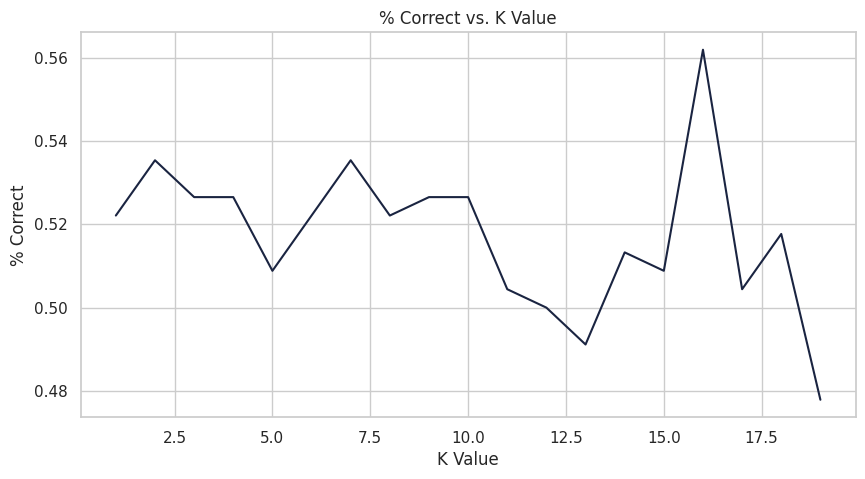

In [72]:
correct = []
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_features,train_labels)
    prediction = knn.predict(test_features)
    correct.append(np.mean(prediction == test_labels))

    plt.figure(figsize=(10, 5))
plt.plot(range(1, 20), correct)
plt.title('% Correct vs. K Value')
plt.xlabel('K Value')
plt.ylabel('% Correct')


#K Nearest Neighbor With Optimal Neighbor (1)
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(train_features,train_labels)
print("Accuracy " + str(knn.score(test_features, test_labels)))
y_pred = knn.predict(test_features)
print(confusion_matrix(test_labels, y_pred))
# print(classification_report(y_test, y_pred))

### Neural Networks

In [73]:
NeuralNetwork = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
NeuralNetwork.fit(train_features, train_labels)
nn_pred = NeuralNetwork.predict(test_features)
print(NeuralNetwork.score(test_features,test_labels))
print(confusion_matrix(test_labels, nn_pred))

0.5663716814159292
[[128   0]
 [ 98   0]]


### SVM

In [74]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [75]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train_features,train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [76]:
pred = clf.predict(test_features)

In [77]:
print(confusion_matrix(test_labels, pred))

[[104  24]
 [ 80  18]]


### False Negatives (FN) without using BERT (FN w/o BERT) for each classification mode

In [78]:
from sklearn.metrics import confusion_matrix

# Function to calculate False Negatives
def calculate_fn(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn

# Logistic Regression
lr_pred = lr_clf.predict(test_features)
lr_fn = calculate_fn(test_labels, lr_pred)
print("Logistic Regression FN w/o BERT:", lr_fn)

# Random Forest
rf_pred = RandForest.predict(test_features)
rf_fn = calculate_fn(test_labels, rf_pred)
print("Random Forest FN w/o BERT:", rf_fn)

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=1)  # Assuming optimal K is 1
knn.fit(train_features, train_labels)
knn_pred = knn.predict(test_features)
knn_fn = calculate_fn(test_labels, knn_pred)
print("KNN FN w/o BERT:", knn_fn)

# Multi-Layer Perceptron
# mlp_pred = NeuralNetwork.predict(test_features)
mlp_fn = calculate_fn(test_labels, nn_pred)
print("MLP FN w/o BERT:", mlp_fn)

# Support Vector Classifier
svc_pred = clf.predict(test_features)
svc_fn = calculate_fn(test_labels, svc_pred)
print("SVC FN w/o BERT:", svc_fn)


Logistic Regression FN w/o BERT: 83
Random Forest FN w/o BERT: 92
KNN FN w/o BERT: 49
MLP FN w/o BERT: 98
SVC FN w/o BERT: 80


In [79]:
# Print the size of the test dataset
print("Size of test dataset:", len(test_labels))


Size of test dataset: 226
